In [1]:
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
from imageio import imread
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd512 import ssd_512
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

import cv2 as cv
import time

%matplotlib inline

/Users/mengwan/anaconda/envs/SSD/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Parameters
weights_path = './models/weights/VGG_VOC0712Plus_SSD_512x512_ft_iter_160000.h5'

input_video_path = './examples/MOT16-05.mp4'
output_video_path = './examples/MOT16-05_output.mp4'

total_frames = 50 # max. number of frames to capture, if -1, process entire stream

In [3]:
# Open input video and retrieve frame size and FPS

video = cv.VideoCapture(input_video_path)
ret, test_frame = video.read()

fps = video.get(cv.CAP_PROP_FPS)
img_height = test_frame.shape[0]
img_width = test_frame.shape[1]

video.release()

In [4]:
# Build model, excerpt from ssd512_inference.ipynb
# 1: Build the Keras model, 

K.clear_session() # Clear previous models from memory.

model = ssd_512(image_size=(img_height, img_width, 3),
                n_classes=20,
                mode='inference',
                l2_regularization=0.0005,
                scales=[0.07, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.05], # The scales for MS COCO are [0.04, 0.1, 0.26, 0.42, 0.58, 0.74, 0.9, 1.06]
                aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5]],
               two_boxes_for_ar1=True,
               steps=[8, 16, 32, 64, 128, 256, 512],
               offsets=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
               clip_boxes=False,
               variances=[0.1, 0.1, 0.2, 0.2],
               normalize_coords=True,
               subtract_mean=[123, 117, 104],
               swap_channels=[2, 1, 0],
               confidence_thresh=0.5,
               iou_threshold=0.45,
               top_k=200,
               nms_max_output_size=400)

# 2: Load the trained weights into the model.

model.load_weights(weights_path, by_name=True)

# 3: Compile the model so that Keras won't complain the next time you load it.

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

In [5]:
# Capture video frames

cap_frames = []

video = cv.VideoCapture(input_video_path)
while(total_frames == -1 or len(cap_frames) < total_frames):
    ret, frame = video.read()
    if ret:
        frameRGB = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        cap_frames.append(frameRGB)
    else:
        break
    
video.release()

In [6]:
# Make batch preds with SSD

input_images = np.array(cap_frames)

start_time = time.time()
y_pred = model.predict(input_images)
end_time = time.time()

print("{} frames processed.".format(len(cap_frames)))
print("Total Time: {} seconds.".format(end_time - start_time))
print("FPS: {}".format(len(cap_frames)/(end_time - start_time)))

50 frames processed.
Total Time: 379.96083307266235 seconds.
FPS: 0.1315925107218569


In [7]:
# Threshold bounding boxes, excerpt from ssd512_inference.ipynb

confidence_threshold = 0.5

y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_thresh[9])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  7.     1.   454.82 181.14 643.42 296.43]
 [ 15.     1.   160.67 143.36 248.91 356.6 ]
 [ 15.     1.    52.97 125.19 138.06 363.19]
 [ 15.     0.94 136.33 182.63 174.57 275.44]
 [ 15.     0.86 294.11 184.92 328.05 281.28]
 [  7.     0.69  -4.2  146.02  94.53 309.43]
 [ 15.     0.68 410.34 191.26 459.49 267.43]
 [  7.     0.53 543.26 202.5  651.12 326.63]]


In [8]:
# Prepare labels

colors = plt.cm.hsv(np.linspace(0, 1, 21))[:, 0:3] * 254 # Colours are in HSV space, but look good anyway
classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

In [9]:
# Draw bounding boxes using OpenCV

output_images = cap_frames.copy()

font = cv.FONT_HERSHEY_SIMPLEX
for i in range(len(output_images)):
    output_img = output_images[i]
    for box in y_pred_thresh[i]:
        xmin = int(box[2] * output_img.shape[1] / img_width)
        ymin = int(box[3] * output_img.shape[0] / img_height)
        xmax = int(box[4] * output_img.shape[1] / img_width)
        ymax = int(box[5] * output_img.shape[0] / img_height)
        color = (colors[int(box[0])][0], colors[int(box[0])][1], colors[int(box[0])][2])
        label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
        output_img = cv.rectangle(output_img, (xmin, ymin), (xmax, ymax), color, 1)
        output_img = cv.rectangle(output_img, 
                                  (xmin, ymin - 13),
                                  (xmin + len(label) * 7 + 2, ymin),
                                  color, 
                                  -1) # Draw a small rectangle as label background
        output_img = cv.putText(output_img, label,
                                (xmin + 1, ymin - 3), 
                                font, 0.4, 
                                (255, 255, 255), 1, 
                                cv.LINE_AA)

### outputs: y_pred_thresh

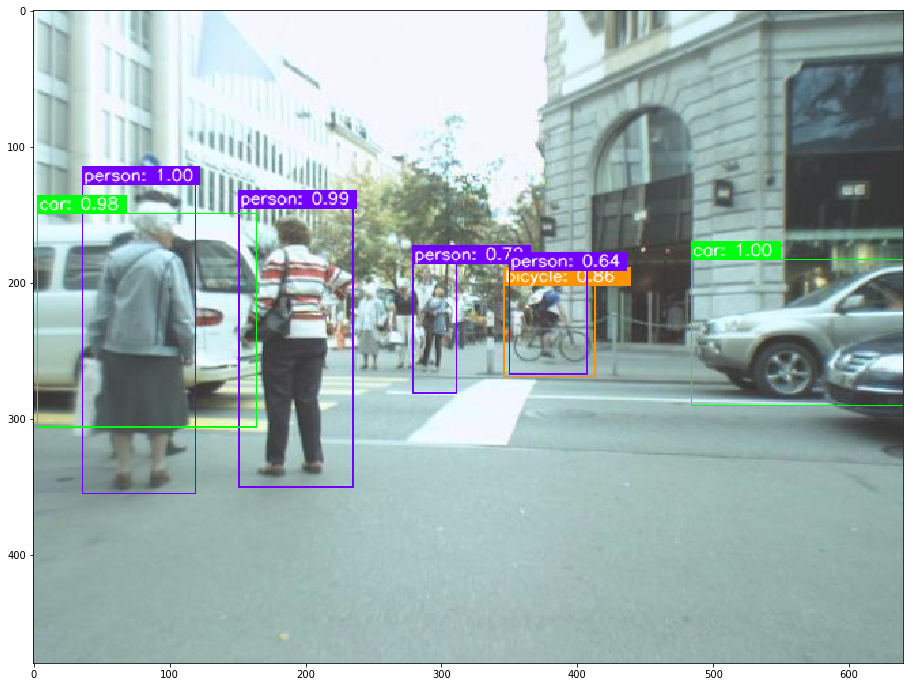

In [10]:
plt.figure(figsize=(20,12))
plt.imshow(output_images[7])

In [11]:
# Output final video, using same FPS as input

fourcc = cv.VideoWriter_fourcc(*'MP4V')
out = cv.VideoWriter()

opened = out.open(output_video_path, fourcc, fps, (img_width, img_height))

for img in output_images:
    img = cv.cvtColor(img, cv.COLOR_RGB2BGR)
    out.write(img)
    
out.release()